# Continuous Variable VQE for long-range molecular interactions

In the following, we illustrate how our code can be used to study the system composed of a pair of QDO oscillators. We focus on a 1-dimensional model for efficiency, but the code generalized to the full-fledged 3d QDO model.

We focus on the case of a diatomic system.

## Imports

In [29]:
from datetime import datetime
from dataclasses import dataclass
import json
%matplotlib inline
import numpy as np
import os
import strawberryfields as sf
import tensorflow as tf

from src.energy_surface import EnergySurface

from src.utils import \
    von_neumann_entropy, \
    renyi_entropy, \
    make_gif, \
    plot_entropy, \
    plot_binding_entropy, \
    plot_binding_curve, \
    plot_wigner, \
    plot_joint_density

In [3]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

Let us define the following `Atom` dataclass to store the QDO parameters later

In [4]:
@dataclass
class Atom:
    m: float
    omega: float
    q: float

You can choose among the following list of atoms. Note that the 'Un' atom corresponds to a fictitious atom with unit parameters.

In [5]:
ATOMIC_PARAMETERS = {
    'Un': {'omega': 1.0000, 'm': 1.0000, 'q': 1.0000},
    'H':  {'omega': 0.4280, 'm': 0.8348, 'q': 0.8295},
    'Ne': {'omega': 1.1933, 'm': 0.3675, 'q': 1.1820},
    'Ar': {'omega': 0.6958, 'm': 0.3562, 'q': 1.3835},
    'Kr': {'omega': 0.6122, 'm': 0.3401, 'q': 1.4635},
    'Xe': {'omega': 0.5115, 'm': 0.3298, 'q': 1.5348},
}

## Preliminaries: defining the inputs of the simulation

Let us first define the various parameters relevant for the definition and the training of the model

In [5]:
args = {
    'layers': 8,
    'cutoff_dim': 5,
    'atom_list': ['Un', 'Un'],
    'active_sd': 0.0001,
    'passive_sd': 0.1,
    'learning_rate': 0.01,
    'epsilon': 1e-3,
    'patience': 30,
    'seed': 42,
    'save_dir': './logs/'
}

args['dimension'] = 1
args['modes'] = len(args['atom_list']) * args['dimension']

distances = list(np.linspace(0.1, 3.5, 70))
thetas = list(np.linspace(0.0, np.pi / 2, 20))

#distances = list(np.linspace(0.3, 3.5, 3))
#thetas = list(np.linspace(np.pi / 4, np.pi / 2, 2))

args['distance_list'] = distances
args['theta_list'] = thetas

args = objectview(args)

By default, Strawberry Fields sets $\hbar=2$. Let us redefine it to fit atomic units conventions

In [ ]:
sf.hbar = 1.0

Let us also set the random seeds for reproducibility of the results

In [ ]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

Let us define a directory where to store the results of the simulation

Let us store the QDO's data into dataclass

In [ ]:
atoms = []

for atom in args.atom_list:

    atoms.append(Atom(
        m=ATOMIC_PARAMETERS[atom]['m'],
        omega=ATOMIC_PARAMETERS[atom]['omega'],
        q=ATOMIC_PARAMETERS[atom]['q']
    ))

We work with the quadratures of the electromagnetic field, which are real valued variables, hence need to be discretized

In [ ]:
x_quadrature_grid = np.linspace(-7.0, 7.0, 400)

## Training

We are finally ready to instanciate a `EnergySurface` object, whose ability is to run a VQE algorithm for each of the specified interatomic distances and angle/model, and store the results of the simulation in the directory defined previously.

In [ ]:
save_dir = os.path.join(
    args.save_dir,
    datetime.now().strftime("%Y.%m.%d.%H.%M.%S")
)

os.makedirs(save_dir, exist_ok=True)

# Save the parameters of the run to the log directory
with open(os.path.join(save_dir, 'args.json'), 'w') as f:
    json.dump(vars(args), f, indent=4)

energy_surface = EnergySurface(
    layers=args.layers,
    distance_list=distances,
    theta_list=thetas,
    x_quadrature_grid=x_quadrature_grid,
    atoms=atoms,
    active_sd=args.active_sd,
    passive_sd=args.passive_sd,
    cutoff_dim=args.cutoff_dim,
    learning_rate=args.learning_rate,
    save_dir=save_dir,
    verbose=False
)

res = energy_surface.construct_energy_surface_parallelized(
    epsilon=args.epsilon,
    patience=args.patience
)

## Postprocessing

Let us load the results of the simulation

In [30]:
dir = 'logs/2023.02.21.13.19.23'
res = np.load(os.path.join(dir, 'results.npy'))
starting_distance = 0

binding_energies = res[:, starting_distance:, -1, -1]
states = res[:, starting_distance:, :-1, :-1]
distances = np.load(os.path.join(dir, 'distance_array.npy'))[starting_distance:]
thetas = np.load(os.path.join(dir, 'angle_array.npy'))
quadrature_grid = np.load(os.path.join(dir, 'quadrature_array.npy'))

entropy_array = von_neumann_entropy(states=states)
renyi_entropy_array = renyi_entropy(states=states, n=2)

with open(os.path.join(dir, 'args.json')) as f:
    args = json.load(f)

We export the data to Mathematica readable format in order to do interpolations and output beautiful plots

In [3]:
mathematica_dir = os.path.join('mathematica', dir.split('/')[1])
os.makedirs(mathematica_dir, exist_ok=True)

In [4]:
distances.astype('float32').tofile(os.path.join(mathematica_dir, 'distances.dat'))
thetas.astype('float32').tofile(os.path.join(mathematica_dir, 'angles.dat'))
binding_energies.astype('float32').tofile(os.path.join(mathematica_dir, 'binding_energies.dat'))
states.astype('complex').tofile(os.path.join(mathematica_dir, 'states.dat'))
quadrature_grid.astype('float32').tofile(os.path.join(mathematica_dir, 'quadrature_grid.dat'))
entropy_array.astype('float32').tofile(os.path.join(mathematica_dir, 'entropies.dat'))
renyi_entropy_array.astype('float32').tofile(os.path.join(mathematica_dir, 'renyi_entropies.dat'))

### Plotting the binding curve

/home/sarkis/git_repositories/qdo/.env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part


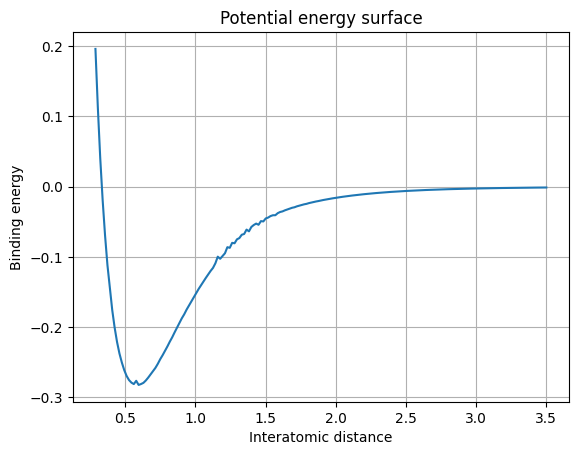

In [7]:
start = 11

plot_binding_curve(
    distance_array=distances[start:],
    binding_energy_array=binding_energies[8, start:]
)

In [31]:
thetas[8]

0.6613879270715354

In [10]:
from math import exp

def interpolation_angle8_startingDistance11(r):
    
    expr = 0.46162512831719266*(exp(-5.473740049665798*(-0.5382686719819294 + r)) - 2/exp(2.736870024832899*(-0.5382686719819294 + r)))
    return expr

### Entanglement entropy

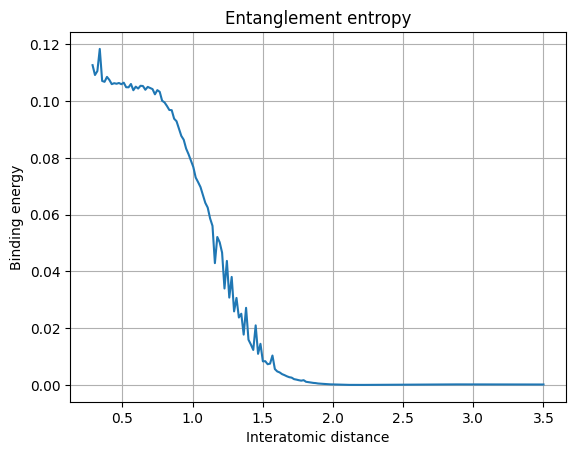

In [8]:
start = 11

plot_entropy(
    distance_array=distances[start:],
    entropy_array=entropy_array[8, start:]
)

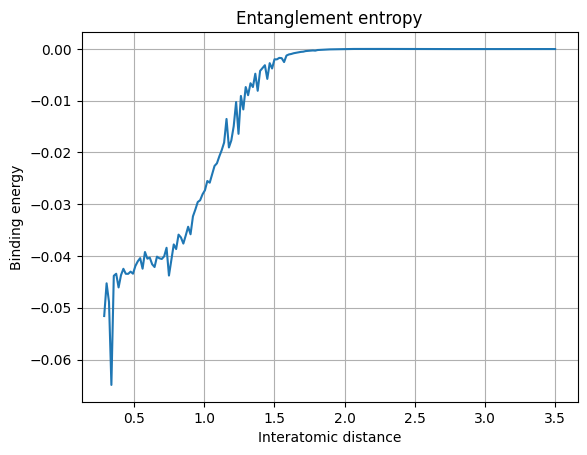

In [9]:
start = 11

plot_entropy(
    distance_array=distances[start:],
    entropy_array=renyi_entropy_array[8, start:]
)

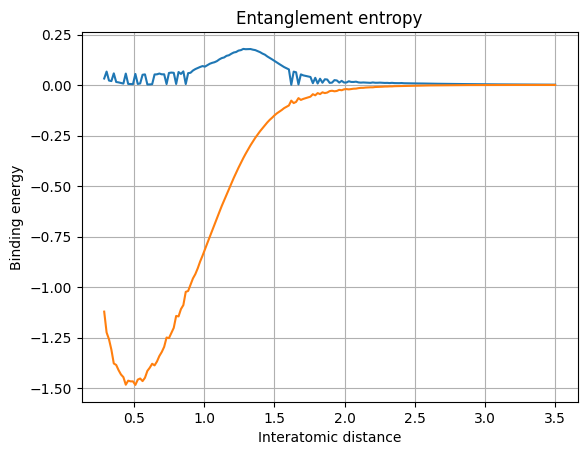

In [28]:
start = 11
angle = 4

plot_binding_entropy(
    distance_array=distances[start:],
    binding_energy_array=binding_energies[angle, start:],
    entropy_array=entropy_array[angle, start:]
)

### Wigner functions vizualization

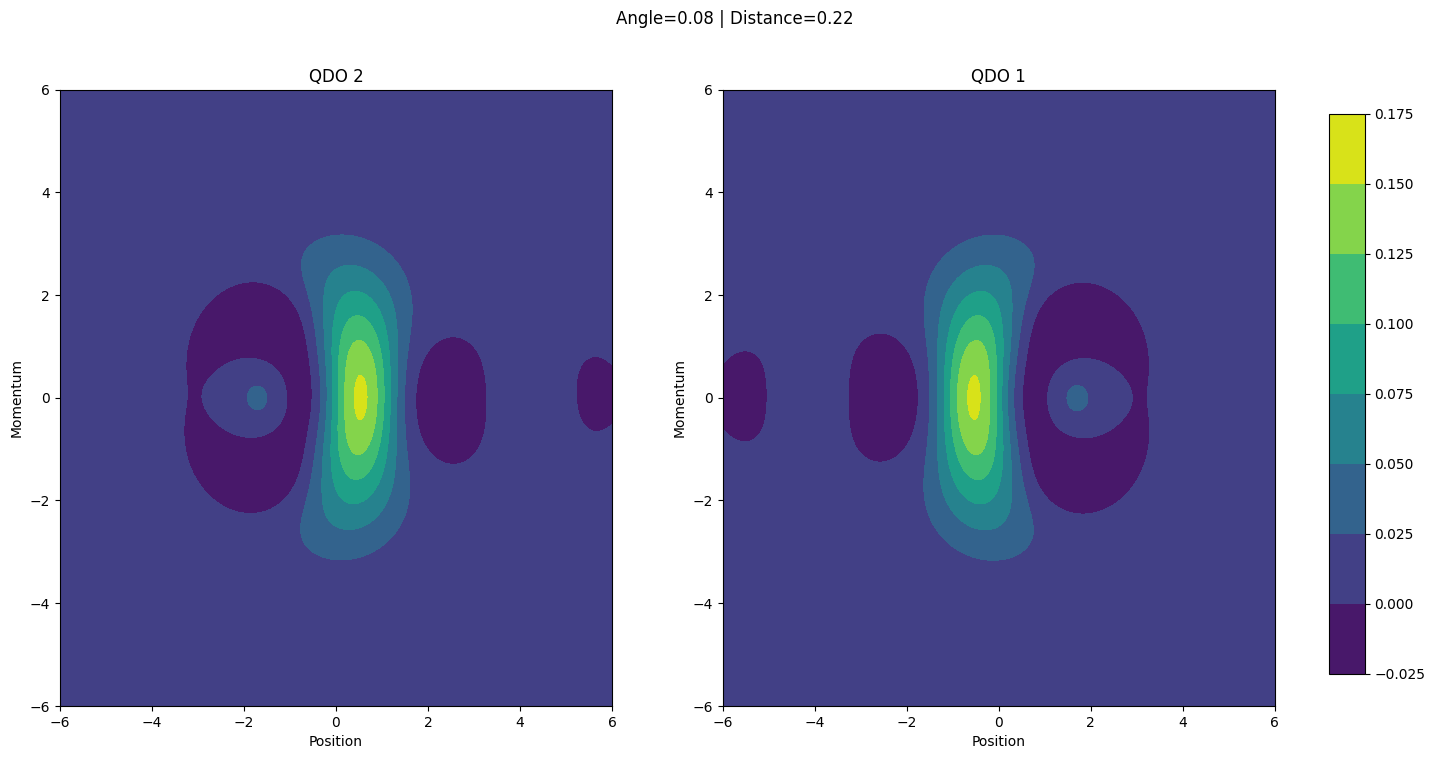

In [4]:
plot_wigner(
    fig_dir=None,
    quadrature_grid=quadrature_grid,
    thetas=thetas,
    distances=distances,
    angle_idx=1,
    distance_idx=7,
    states=states,
    cutoff_dim=args['cutoff_dim']
)

In [14]:
thetas[8]

0.6613879270715354

In [13]:
X, P = np.meshgrid(quadrature_grid, quadrature_grid)

angle = 8
fig_dir = os.path.join(dir, 'figures', 'wigner', 'angle={:.4f}'.format(thetas[angle]))

for distance in range(distances.shape[0]):
   
    plot_wigner(
        fig_dir=fig_dir,
        quadrature_grid=quadrature_grid,
        thetas=thetas,
        distances=distances,
        angle_idx=angle,
        distance_idx=distance,
        states=states,
        cutoff_dim=args['cutoff_dim'],
    )

make_gif(
    frames_dir=fig_dir,
    duration=20
)



2023-02-22 15:03:57.770601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-22 15:03:57.770839: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 15:03:57.770856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uni-OptiPlex-7480-AIO): /proc/driver/nvidia/version does not exist
2023-02-22 15:03:57.772192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Moviepy - Building video logs/2023.02.21.13.19.23/figures/wigner/angle=0.6614/animation.mp4.
Moviepy - Writing video logs/2023.02.21.13.19.23/figures/wigner/angle=0.6614/animation.mp4



Moviepy - Done !
Moviepy - video ready logs/2023.02.21.13.19.23/figures/wigner/angle=0.6614/animation.mp4


## Joint density vizualization

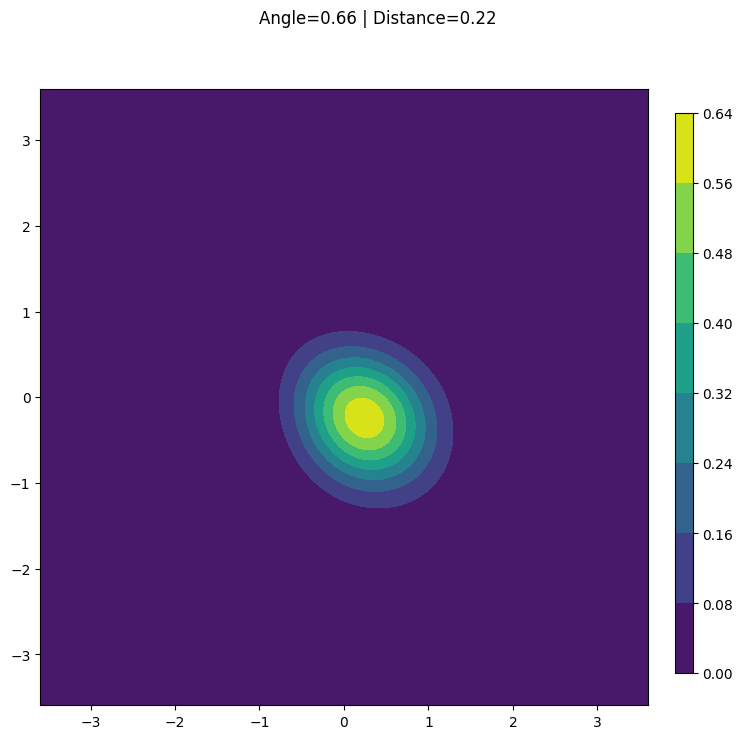

In [8]:
plot_joint_density(
    fig_dir=None,
    quadrature_grid=quadrature_grid[100: -100],
    thetas=thetas,
    distances=distances,
    angle_idx=8,
    distance_idx=7,
    states=states,
    cutoff_dim=args['cutoff_dim']
)

In [22]:
thetas[10]

0.8267349088394192

In [27]:
angle = 4
fig_dir = os.path.join(dir, 'figures', 'joint_density', 'angle={:.4f}'.format(thetas[angle]))

for distance in range(distances.shape[0]):
   
    plot_joint_density(
        fig_dir=fig_dir,
        quadrature_grid=quadrature_grid[100: -100],
        thetas=thetas,
        distances=distances,
        angle_idx=angle,
        distance_idx=distance,
        states=states,
        cutoff_dim=args['cutoff_dim']
    )

make_gif(
    frames_dir=fig_dir,
    duration=20
)

Moviepy - Building video logs/2023.02.21.13.19.23/figures/joint_density/angle=0.3307/animation.mp4.
Moviepy - Writing video logs/2023.02.21.13.19.23/figures/joint_density/angle=0.3307/animation.mp4



Moviepy - Done !
Moviepy - video ready logs/2023.02.21.13.19.23/figures/joint_density/angle=0.3307/animation.mp4
